# Import Libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os
import json
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig
from trl import SFTTrainer


# Import Dataset

In [3]:
dataset = load_dataset("bhatthars/nbme_patient_notes",split='train')

In [4]:
split_dataset = dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset['train']
eval_dataset = split_dataset['test']

# Load base model and tokenizer using 4-bit quantization

In [5]:
base_model = 'meta-llama/Llama-2-7b-chat-hf'

In [6]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

In [7]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config=quant_config,
    device_map={"": 0},use_auth_token='auth_token'
    
)
model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True,token="auth_token")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Define PEFT QLoRA arguments

In [9]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

In [10]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In [ ]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset = eval_dataset,
    peft_config=peft_params,
    dataset_text_field="Prompt",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=training_params,
    packing=False,
)

# Train

In [12]:
trainer.train()

Step,Training Loss
25,2.351700
50,1.708800
75,1.528400
100,1.490600
125,1.420900
150,1.425000
175,1.362900
200,1.410400


TrainOutput(global_step=200, training_loss=1.5873416137695313, metrics={'train_runtime': 550.6409, 'train_samples_per_second': 1.453, 'train_steps_per_second': 0.363, 'total_flos': 1.2677846263922688e+16, 'train_loss': 1.5873416137695313, 'epoch': 1.0})

# Save and Evaluate

In [13]:
trainer.model.save_pretrained("metadata/fine_tuned")
trainer.tokenizer.save_pretrained("metadata/tokenft")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('metadata/tokenft/tokenizer_config.json',
 'metadata/tokenft/special_tokens_map.json',
 'metadata/tokenft/tokenizer.json')

In [21]:
# from tensorboard import notebook
# log_dir = "results/runs"
# notebook.start("--logdir {} --port 4000".format(log_dir))


In [14]:
# Evaluate the model
metrics = trainer.evaluate()
print(metrics)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'eval_loss': 1.3755254745483398, 'eval_runtime': 69.7525, 'eval_samples_per_second': 2.867, 'eval_steps_per_second': 0.358, 'epoch': 1.0}


In [15]:
fine_tuned_model_path = "metadata/fine_tuned"
fine_tuned_tokenizer_path = "metadata/tokenft"

In [16]:
model = AutoModelForCausalLM.from_pretrained(
    fine_tuned_model_path,
    device_map={"": 0},
    use_auth_token='auth_token'
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
tokenizer = AutoTokenizer.from_pretrained(fine_tuned_tokenizer_path, trust_remote_code=True,token="auth_token")

In [18]:
with open("preprocessed_data.json","r") as file:
    data = json.load(file)

In [19]:
ph = data['0']

In [20]:
eval_dataset['Prompt'][1]

'<s>[INST]<<SYS>>You are a resourceful medical assistant. Please ensure your answers are unbiased. Make sure the answers are from the text provided.<</SYS>>Patient Note: 17 yo male with no PMH presents with 3-4 months of palpitations\r\n-episodes occur randomly, no associated with activity, associated with shortness of breath and pre-syncope\r\n-no sweating, feeling of impending doom, anxiety with episodes, no diarrhea\r\n-takes adderall a few times that is prescribed to friend, however has been taking this for a year now\r\n-no history of thyroid problems\r\nPMH: none\r\nMeds: adderall (not prescribed)\r\nFamHx: Mom- "thyroid problem"; dad- heart attack at 52\r\nSocial: lives with roomate; 3-4 alcoholic beverages/week, no durgs, sexually active w girlfriend and uses condoms.\nExtract phrases from this text which may help understand the patient\'s medical condition.[/INST]dad- heart attack, Mom- "thyroid problem, episodes, adderall, adderall, shortness of breath, palpitations, 3-4 mont

In [21]:
idx = eval_dataset["Prompt"][1].index("[/INST]") + 7

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer,max_length=435, truncation = True)

result = pipe(eval_dataset["Prompt"][1][:idx])
print(result[0]['generated_text'])

<s>[INST]<<SYS>>You are a resourceful medical assistant. Please ensure your answers are unbiased. Make sure the answers are from the text provided.<</SYS>>Patient Note: 17 yo male with no PMH presents with 3-4 months of palpitations
-episodes occur randomly, no associated with activity, associated with shortness of breath and pre-syncope
-no sweating, feeling of impending doom, anxiety with episodes, no diarrhea
-takes adderall a few times that is prescribed to friend, however has been taking this for a year now
-no history of thyroid problems
PMH: none
Meds: adderall (not prescribed)
FamHx: Mom- "thyroid problem"; dad- heart attack at 52
Social: lives with roomate; 3-4 alcoholic beverages/week, no durgs, sexually active w girlfriend and uses condoms.
Extract phrases from this text which may help understand the patient's medical condition.[/INST]Mom- "thyroid problem", palpitations, no diarrhea, adderall, 17 yo, male, shortness of breath, pre-syncope, 3-4 months, 3-4 months, 3-4 months

# Evaluate

In [1]:
# !pip install streamlit

In [8]:
def generate(patient_note, model_name, tokenizer_version):
    system_prompt = system_prompt = "You are a resourceful medical assistant. Please ensure your answers are unbiased. Make sure the answers are from the text provided"
    pipe = pipeline(task="text-generation",model = model_name, tokenizer = tokenizer_version,max_length=600)
    result = pipe(f"<s>[INST]<<SYS>>{system_prompt}<<SYS>>{patient_note} [/INST]")
    
    # process the keywords
    s1 = result[0]['generated_text'].split("[/INST]")
    lst = s1[1].split(',')
    a  = set()
    for x in lst: a.add(x)
    return {
        'response':s1,
        'keywords': a
    }

In [1]:
predicted = []
for i in range((eval_dataset.shape[0])):
    user_prompt = eval_dataset['Prompt'][i].split('[/INST]')[0].split('<</SYS>>')[1]
    result = generate(user_prompt,model,tokenizer)
    predicted_keywords = list(result['keywords'])
    predicted.append(predicted_keywords)

In [10]:
ground_truth =  [ x.split('[/INST]')[1] for x in eval_dataset['Prompt'] ] 

In [11]:
lst = []
for x in ground_truth:
    lst.append(x.replace("</s>","").split(','))

In [12]:
import csv
import os

def file_to_csv(lst,filename):
    # Open the file in write mode
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the data to the CSV file
        writer.writerows(lst)

    print("Data saved to", filename)

In [13]:
file_to_csv(lst,"Ground_truth.csv")
file_to_csv(predicted,"Predicted.csv")

Data saved to Ground_truth.csv
Data saved to Predicted.csv


In [ ]:
max_len = max([len(x) for x in ground_truth])

In [ ]:
min_len = np.std(([len(x) for x in ground_truth]))

(array([ 45., 264., 250., 130.,  65.,  27.,  12.,   3.,   3.,   1.]),
 array([ 61. , 126.3, 191.6, 256.9, 322.2, 387.5, 452.8, 518.1, 583.4,
        648.7, 714. ]),
 <BarContainer object of 10 artists>)

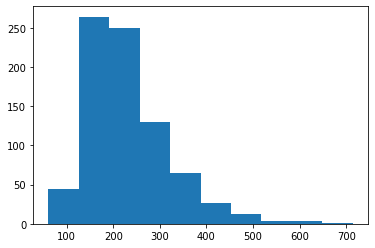

In [52]:
arr = [len(x) for x in ground_truth]
plt.hist(arr)

### Comparing ground_truth and predicted

In [16]:
ground_truth =  [ x.split('[/INST]')[1] for x in eval_dataset['Prompt'] ] 
type(ground_truth[0])

str

In [17]:
eval_dataset.shape[0]

200

In [19]:
predicted = []
for i in range((eval_dataset.shape[0])):
    user_prompt = eval_dataset['Prompt'][i].split('[/INST]')[0].split('<</SYS>>')[1]
    result = generate(user_prompt,model,tokenizer)
    predicted_keywords = list(result['keywords'])
    predicted.append(predicted_keywords)
    print(predicted_keywords)
    

[' Mrs', ' 2-3 glasses of wine per weekend', ' F.', ' Ibuprofen', ' headache', ' 1 day hx', ' 3-4 marjuana joints per week', ' 3 episodes of vomittus', ' Tylenol', ' nausea', ' 20 yo', ' feeling "warm" this morning', ' "I have never felt this bad"', ' photophobia', ' vomittus', ' 24 hrs', ' LMP 2 wks ago', ' constant', ' no loss of consciousness', 'F']
[' No weight loss', ' increased eating', ' No BM changes', ' No weight gain', ' difficulty staying asleep', 'Female', ' HTN', ' No SOB', ' No amnesia', ' 67 YO', ' No urinary incontinence', ' No confusion', ' No urinary changes', ' depressed mood', ' No palpitations', ' reduced interest in doing enjoyrable activities', ' No tremors', ' No recent travel', ' difficulty falling asleep', ' No nausea', ' Mother - MDD', ' 3 weeks of difficulty sleepng', ' difficulty sleeping with menopause changes', ' No recent trauma..\n\nDenies suicidal thoughts', ' No difficulty concentrating', ' No abdominal pain', ' No weakness', ' No diarrhea', ' No urin

In [20]:
lst = []
for x in ground_truth:
    lst.append(x.replace("</s>","").split(','))


In [58]:
for i,j in zip(lst[0:10],predicted):
    i.sort()
    j.sort()
    print("Ground_Truth with length",len(i)," : " ,i)
    

#     print("\n")
    print("Predicted with length",len(j)," : ",j)
    
    matches = list(set(i).intersection(set(j)))
    print("Common Groud with length",len(matches)," : ",matches)
    print("\n\n\n")

Ground_Truth with length 11  :  [' 17 yo', ' Denies shortness of breath', ' asthma', ' chest pain', ' m', ' one day history', ' sharp', ' stuffed nose', ' tried albuterol without relief', ' worse with deep inspiration', 'subjective fever']
Predicted with length 19  :  [' 17 yo', ' 3-4 days', ' albuterol inhaler without relief', ' asthma', ' chest pain', ' mild subjective fever', ' muscle ach', ' muscle aches', ' no chills', ' no known trauma to the area', ' no other areas of pain', ' no shortness of breath', ' no sick contacts', ' senior in high school', ' sharp chest pain', ' stuffed nose', ' tylenol without relief', ' worse with deep inspiration', 'Of note he has been experiencing muscle aches']
Common Groud with length 5  :  [' chest pain', ' 17 yo', ' worse with deep inspiration', ' stuffed nose', ' asthma']




Ground_Truth with length 12  :  [' 20 yo', ' FH migrains', ' No sick contacts', ' URI symptoms', ' female', ' headache all over', ' ibuprofen did not relieve', ' mother mig

### Rouge Score

In [6]:
import csv
def csv_to_list(path):
    with open(path, 'r') as file:
        reader = csv.reader(file)
        data = list(reader)
    return data

ground_truth = csv_to_list('Ground_truth.csv')
predicted = csv_to_list('Predicted.csv')


In [59]:
!pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable


In [7]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'],use_stemmer=True)



In [8]:
def cal_rouge_score(ground_truth,predicted): 
    plist = []
    rlist = []
    flist = []
    
    for i,j in zip(ground_truth,predicted):
        i.sort()
        j.sort()
        matches = list(set(i).intersection(set(j)))
        text1 = ' '.join(i)
        text2 = ' '.join(j)
        scores = scorer.score(text1, text2)
        
        print("Ground_Truth with length",len(i)," : " ,i)
        print("Predicted with length",len(j)," : ",j)
        print("Common Groud with length",len(matches)," : ",matches)
        
        print(scores.items())
        for key, value in scores.items():
            print(f"{key}: Precision: {value.precision}, Recall: {value.recall}, F1: {value.fmeasure}")
            plist.append(value.precision)
            rlist.append(value.recall)
            flist.append(value.fmeasure)
        
        print("\n\n\n")
    return plist, rlist, flist

In [9]:
precision, recall, f1 = cal_rouge_score(ground_truth,predicted)

Ground_Truth with length 13  :  [' 1 day', ' 20 yo', ' F', ' Headache is diffuse', ' Ibuprofen not alleviated the pain', ' feeling "warm"', ' headache diffuse', ' lives with roomate', ' nausea', ' photophobia', ' roomate who is not sick', ' vomittus', 'Tylenol not alleviated the pain']
Predicted with length 20  :  [' "I have never felt this bad"', ' 1 day hx', ' 2-3 glasses of wine per weekend', ' 20 yo', ' 24 hrs', ' 3 episodes of vomittus', ' 3-4 marjuana joints per week', ' F.', ' Ibuprofen', ' LMP 2 wks ago', ' Mrs', ' Tylenol', ' constant', ' feeling "warm" this morning', ' headache', ' nausea', ' no loss of consciousness', ' photophobia', ' vomittus', 'F']
Common Groud with length 4  :  [' vomittus', ' photophobia', ' nausea', ' 20 yo']
dict_items([('rouge1', Score(precision=0.25, recall=0.3939393939393939, fmeasure=0.30588235294117644)), ('rouge2', Score(precision=0.058823529411764705, recall=0.09375, fmeasure=0.07228915662650601)), ('rougeL', Score(precision=0.23076923076923078

In [11]:
p = np.reshape(precision,(200,3))
r = np.reshape(recall,(200,3))
f1 = np.reshape(f1,(200,3))

In [12]:
precision_df = pd.DataFrame(p,columns=['rouge1','rouge2','rougeL'])
recall_df = pd.DataFrame(r,columns=['rouge1','rouge2','rougeL'])
f1_df = pd.DataFrame(f1,columns=['rouge1','rouge2','rougeL'])

In [14]:
precision_df.head()

,rouge1,rouge2,rougeL
0,0.250000,0.058824,0.230769
1,0.236842,0.141593,0.166667
2,0.518519,0.283019,0.370370
3,0.871795,0.578947,0.461538
4,0.333333,0.221053,0.260417


### Precision vs Data Points

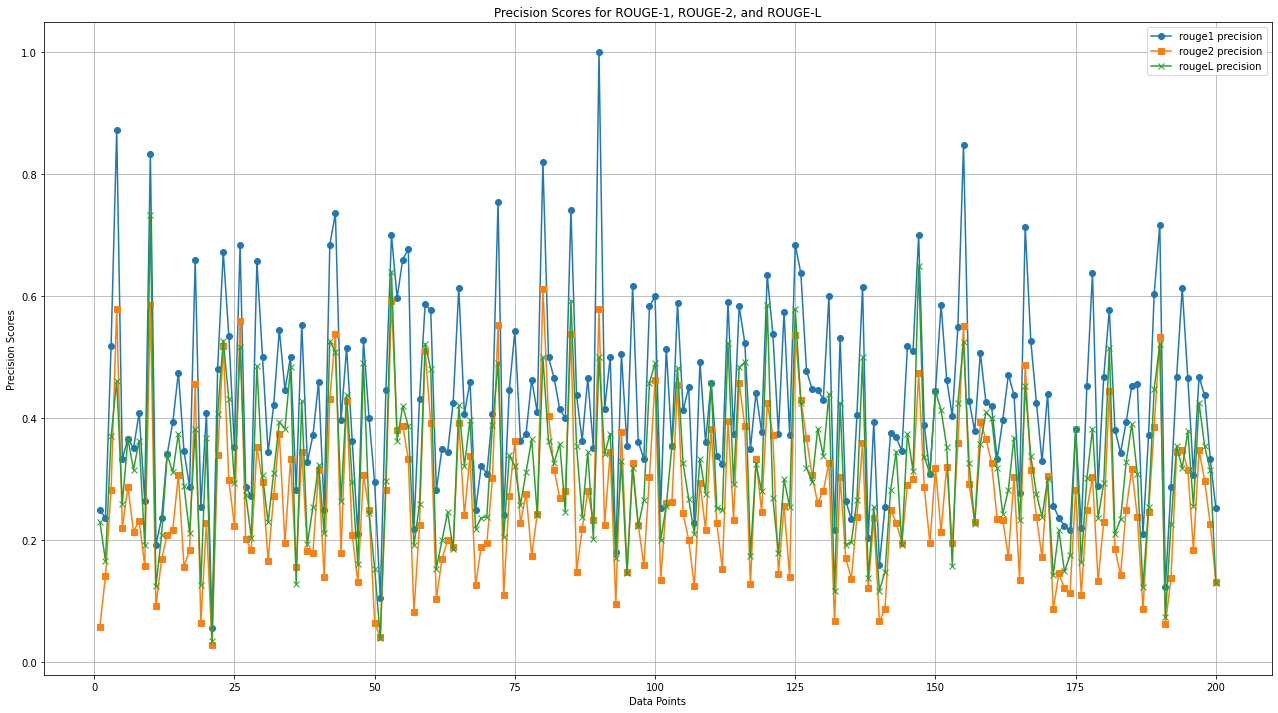

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(22,12))

plt.plot(range(1,201),precision_df['rouge1'], label='rouge1 precision',marker='o')
plt.plot(range(1,201),precision_df['rouge2'], label='rouge2 precision',marker='s')
plt.plot(range(1,201),precision_df['rougeL'], label='rougeL precision',marker='x')

# Add labels and title
plt.xlabel("Data Points")
plt.ylabel("Precision Scores")
plt.title("Precision Scores for ROUGE-1, ROUGE-2, and ROUGE-L")


# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()




### Ground_Truth_Lengths Vs Rouge Metrics

In [17]:
ground_truth_lengths = [len(x) for x in predicted]

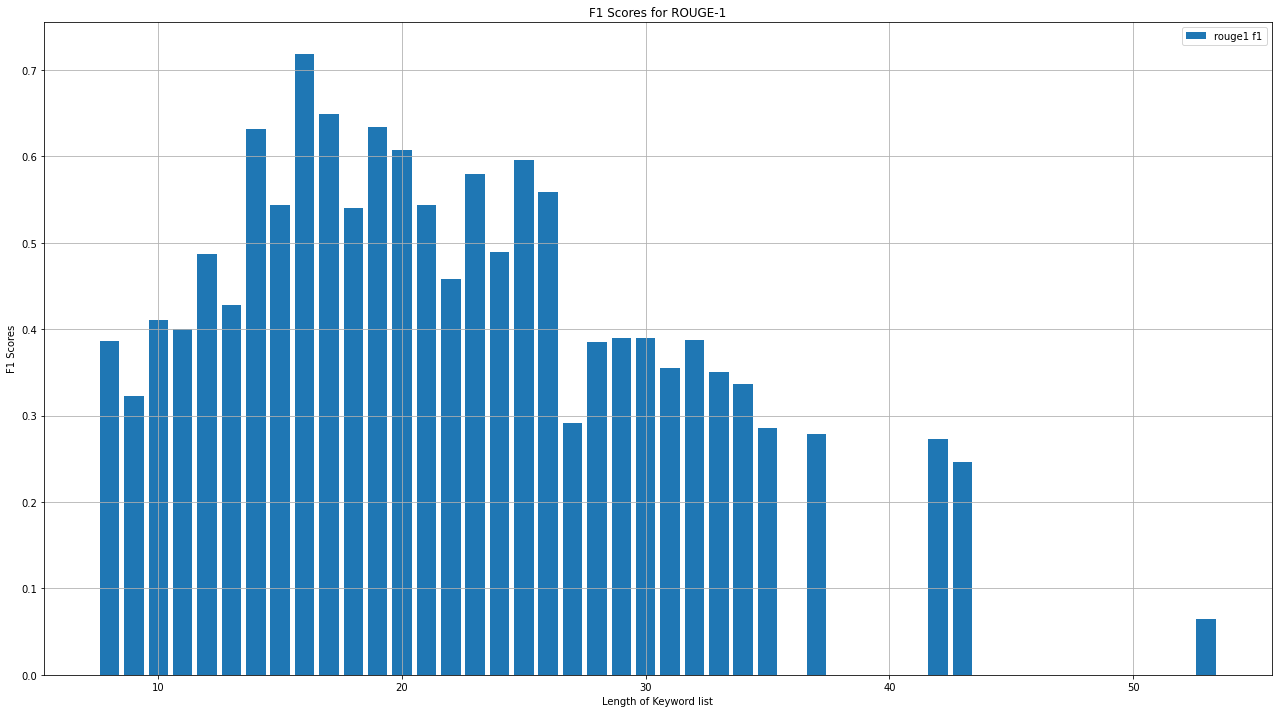

In [22]:
plt.figure(figsize=(22,12))

plt.bar(f1_df['gt_lengths'],f1_df['rougeL'], label='rouge1 f1')
# plt.plot(ground_truth_lengths,precision_df['rouge2'], label='rouge2 precision',marker='s')
# plt.plot(ground_truth_lengths,precision_df['rougeL'], label='rougeL precision',marker='x')

# Add labels and title
plt.xlabel("Length of Keyword list")
plt.ylabel("F1 Scores")
plt.title("F1 Scores for ROUGE-1")


# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [19]:
f1_df['gt_lengths'] = ground_truth_lengths

In [20]:
f1_df.sort_values(by='gt_lengths',ascending=True,inplace=True)

### Patient_Note_Length vs Rouge_Metrics

In [46]:
eval_dataset['Prompt'][0]

"<s>[INST]<<SYS>>You are a resourceful medical assistant. Please ensure your answers are unbiased. Make sure the answers are from the text provided.<</SYS>>Patient Note: Karin Moore, a 45-year-old female, has come to the outpatient clinic with episodes of nervousness. \r\n- the symptoms started 2 months ago, suddenlly, it is getting worse, constant no  alleviated or aggavated factors.\r\n- she also c/o increase of symptoms in the Sunday evening when she has a apresentation in he school, she has loss of energy, difficulty to started sleep, occasional headache. \r\n- she denies, SOB, diarrhea, cold intolencace, constipation, tremors, chest pain, no suicidal toughts.\r\nROS: none except as above\r\nPNH: none\r\nAll: none, Meds: OTC tylenol\r\nFhx: fther died at age 65 of MI.\r\nObgyn: LMP 1 week ago, regular periods.\r\nSocial: no tobacco use,  occasional alcohol use, no illicit drugs. she works a Englisgh Profession, with stressful at job.\nExtract phrases from this text which may help u

In [23]:
user_prompts =  [x.split("<</SYS>>")[1].split("[/INST]")[0] for x in eval_dataset['Prompt'] ]

In [24]:
user_prompts_lengths = [len(x) for x in user_prompts]

In [25]:
user_prompts_lengths

[602,
 1055,
 825,
 910,
 735,
 1051,
 832,
 817,
 633,
 1011,
 1052,
 1028,
 1055,
 1055,
 884,
 1054,
 822,
 962,
 898,
 1054,
 832,
 1054,
 878,
 890,
 705,
 879,
 898,
 896,
 1053,
 967,
 1020,
 704,
 818,
 873,
 1009,
 817,
 1055,
 828,
 1052,
 914,
 1007,
 774,
 705,
 771,
 888,
 952,
 1055,
 1055,
 844,
 1053,
 1037,
 763,
 980,
 1005,
 917,
 404,
 990,
 1052,
 876,
 679,
 866,
 1053,
 1039,
 806,
 641,
 1047,
 659,
 838,
 950,
 842,
 715,
 888,
 786,
 1025,
 1053,
 718,
 982,
 748,
 884,
 916,
 683,
 963,
 1055,
 1052,
 963,
 969,
 645,
 1042,
 901,
 1049,
 1054,
 749,
 819,
 1024,
 969,
 615,
 666,
 945,
 1055,
 1044,
 683,
 1050,
 1025,
 974,
 904,
 961,
 1032,
 1051,
 869,
 866,
 1051,
 1044,
 907,
 733,
 1055,
 1027,
 930,
 901,
 523,
 979,
 1033,
 1052,
 1041,
 762,
 976,
 1046,
 858,
 1054,
 947,
 1036,
 957,
 931,
 1055,
 1038,
 1046,
 1052,
 680,
 982,
 934,
 927,
 521,
 681,
 888,
 821,
 929,
 940,
 1054,
 1055,
 950,
 1000,
 841,
 1030,
 977,
 942,
 1053,
 1055,
 983,

In [26]:
f1c = f1_df.copy()
f1c['prompt_lengths'] = user_prompts_lengths
f1c.sort_values(by='prompt_lengths',ascending=True,inplace=True)

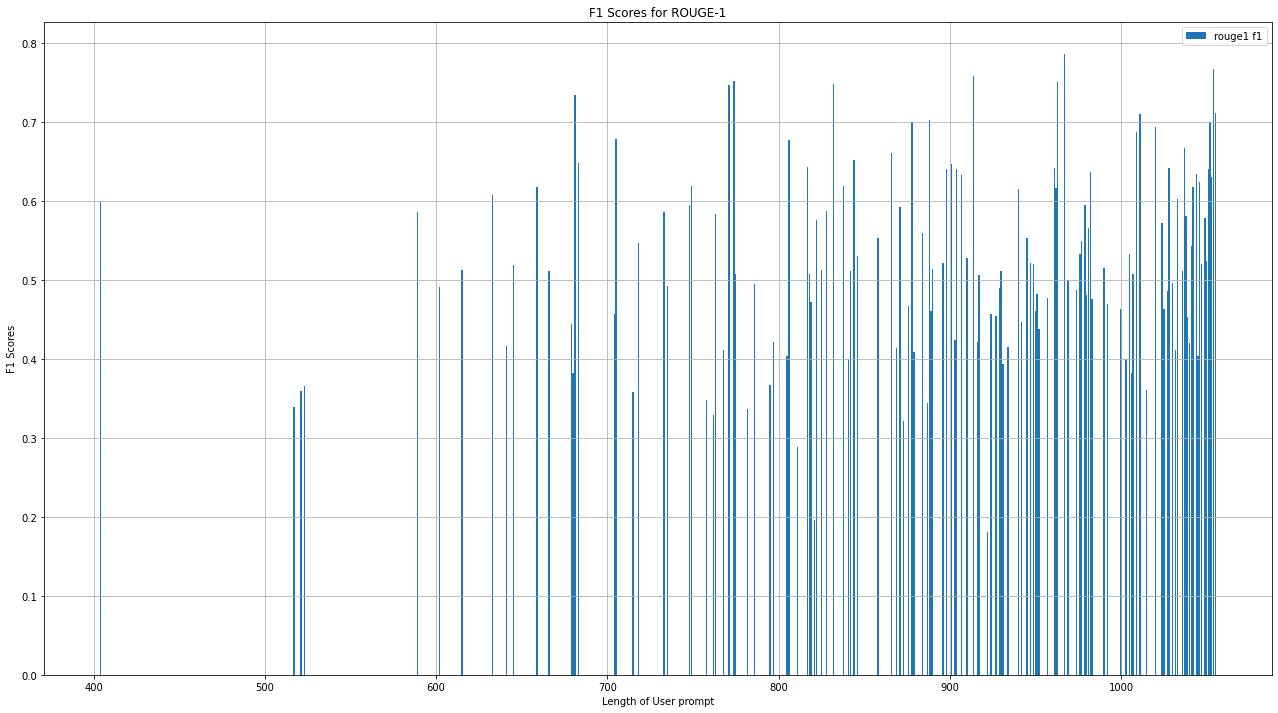

In [28]:
plt.figure(figsize=(22,12))

plt.bar(f1c['prompt_lengths'],f1c['rouge1'], label='rouge1 f1')
# plt.plot(ground_truth_lengths,precision_df['rouge2'], label='rouge2 precision',marker='s')
# plt.plot(ground_truth_lengths,precision_df['rougeL'], label='rougeL precision',marker='x')

# Add labels and title
plt.xlabel("Length of User prompt")
plt.ylabel("F1 Scores")
plt.title("F1 Scores for ROUGE-1")


# Add legend and grid
plt.legend()
plt.grid()

# Show the plot
plt.show()
